<a href="https://colab.research.google.com/github/huseyin-yigit-ulker/Machine_learning_assignments/blob/main/ass3/Assignment_3_H%C3%BCseyin_Yi%C4%9Fit_%C3%9Clker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment-3

**Due Date:** 14.12.2022 

---------------------------------------

**Instructor:** Erkut Erdem

**TA:** Sibel Kapan

---------------------------------------

**Student:** Hüseyin Yiğit Ülker

**Github Classroom:** https://classroom.github.com/a/Wv6S7qnL



## Part I: Theory Questions

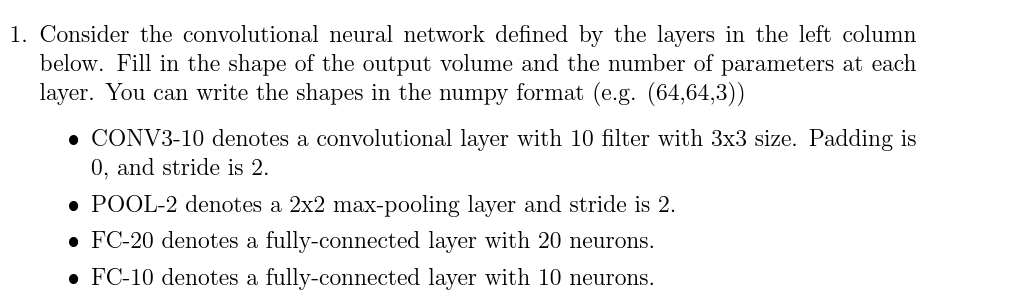

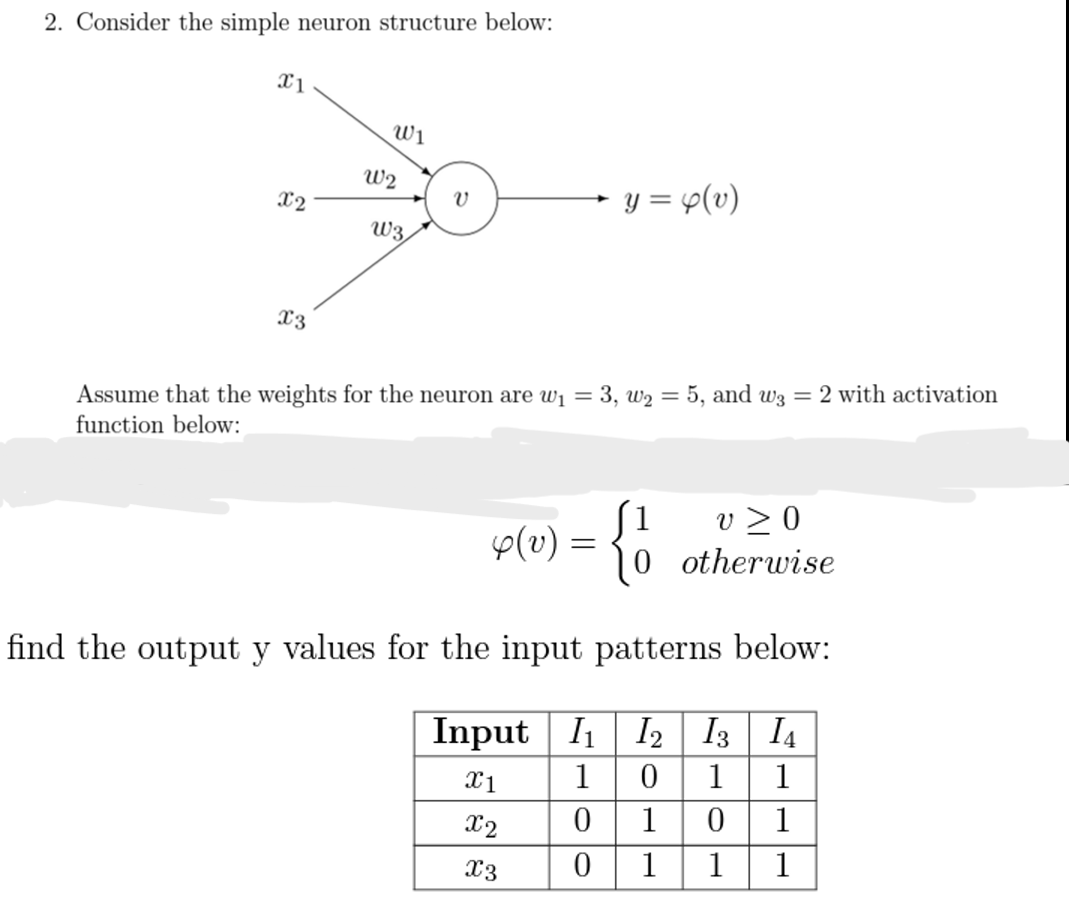

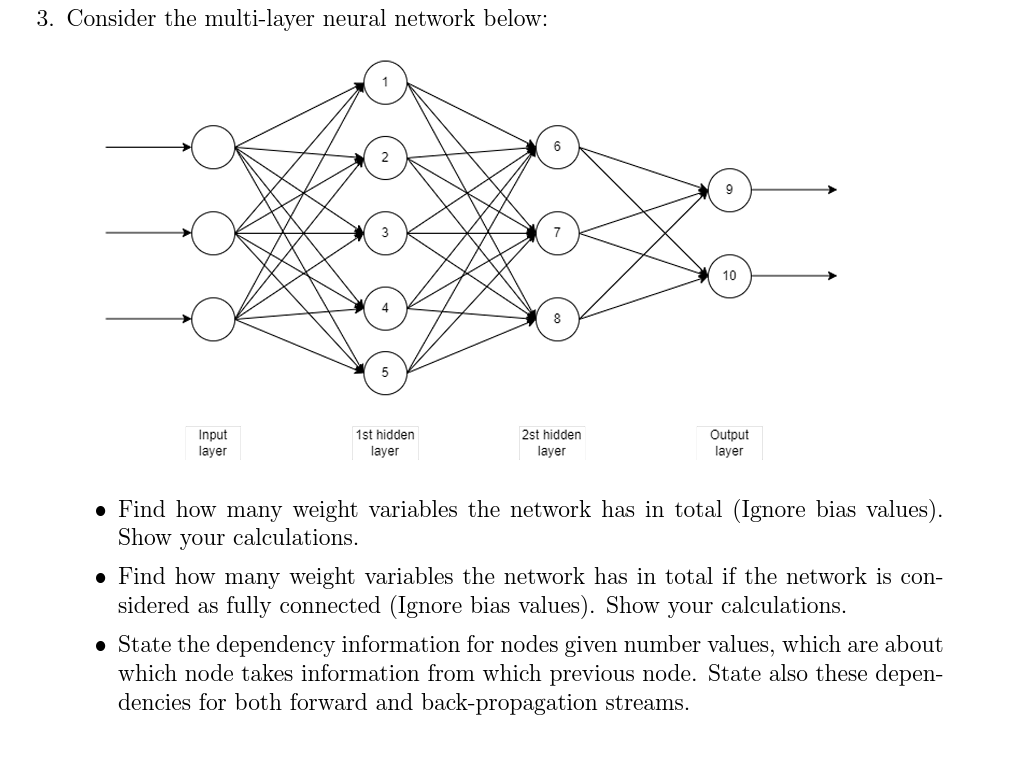

## Part II: Classification of Flower Species using Neural Network


### Dataset Upload

Dataset uploaded from Drive or local

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
data_path = 'https://drive.google.com/file/d/1PyTLK4lCJR7kvntCTxyiTSU5vegDw2dz/view?usp=sharing'
  
# to get the id part of the file
id = data_path.split("/")[-2]
 

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('flowers.zip')  

In [ ]:
! unzip flowers.zip -d data

In [ ]:
import os
import numpy as np
import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.special import softmax
from numpy import argmax
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix

In [ ]:
ROOT_PATH = '/content/data/flowers/'
training_path = f'{ROOT_PATH}/train'
test_path = f'{ROOT_PATH}/test'

In [ ]:
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
jitter=(0.1,0.1,0.1)

In [ ]:
mean_g = [0.554]
std_g = [0.231]
jitter_g=(0.1)

In [ ]:
image_size = 32      # 32x32, 64x64, 128x128
batch_size = 128

In [ ]:
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean_g,std_g)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(jitter_g),    # about saturation brightness vs.
    transforms.ToTensor(),
      transforms.Grayscale(),
    transforms.Normalize(mean_g,std_g),
    transforms.RandomErasing()      #randomly erasing pixels 
])

In [ ]:
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)

In [ ]:
test_dataset = datasets.ImageFolder(test_path, transform=main_transform)

In [ ]:
for i in os.listdir(training_path):
    print(i+" class has "+str(len(os.listdir(training_path+"/"+i)))+" data")

sunflower class has 1400 data
dandelion class has 1400 data
rose class has 1400 data
daisy class has 1400 data
lotus class has 1400 data
bellflower class has 1400 data
tulip class has 1400 data


In [ ]:
for i in os.listdir(test_path):
    print(i+" class has "+str(len(os.listdir(test_path+"/"+i)))+" data")

sunflower class has 200 data
dandelion class has 200 data
rose class has 200 data
daisy class has 200 data
lotus class has 200 data
bellflower class has 200 data
tulip class has 200 data


###Multi Layer Neural Network

In [ ]:
test_dataset[0][1]

0

In [ ]:
def split(data):
  x=[]
  y=[]
  for i in data:
    y_=np.zeros((7,))
    y_[i[1]]=1
    y.append(y_)
    x.append(np.array(i[0]))
  return np.array(x),np.array(y)

In [ ]:
X_train,Y_train=split(train_dataset)

In [ ]:
X_test,Y_test=split(test_dataset)

In [ ]:
Y_test.shape

(1400, 7)

In [ ]:
Y_train.shape

(9800, 7)

In [ ]:
X_train_flatten = X_train.reshape(len(X_train),X_train.shape[2]*X_train.shape[3])
X_test_flatten = X_test.reshape(len(X_test),X_test.shape[2]*X_test.shape[3])

In [ ]:
X_train_flatten.shape

(9800, 1024)

In [ ]:
X_test_flatten.shape

(1400, 1024)

In [ ]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (1024, 9800)
x test:  (1024, 1400)
y train:  (7, 9800)
y test:  (7, 1400)


In [ ]:
def initialize_parameters_and_layer_sizes_NN(x_train, y_train,hidden_layer_data):
    parameters = {"weight1": np.random.randn(hidden_layer_data[1],x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((hidden_layer_data[1],1)),
                  "weight2": np.random.randn(y_train.shape[0],hidden_layer_data[1]) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

In [ ]:
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

In [ ]:
def forward_propagation_NN(x_train, parameters):
    Z1 = np.dot(parameters["weight1"],x_train)+parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [ ]:
# Compute cost
def compute_cross_entropy_NN(A2, Y, parameters):
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

In [ ]:
def backward_propagation_NN(parameters, cache, X, Y):
    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

In [ ]:
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

In [ ]:
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((7,x_test.shape[1]))
    for i in range(A2.shape[1]):
      result = argmax(softmax(A2[:,i]))
      Y_prediction[result,i]=1
    return Y_prediction

In [ ]:
def multiclass_accuracy(y_test,y_pred):
  pred = np.zeros((x_test.shape[1],))
  test = np.zeros((x_test.shape[1],))
  for i in range(y_test.shape[1]):
    result_pred = argmax(softmax(y_pred[:,i]))
    result_test = argmax(softmax(y_test[:,i]))
    pred[i] = result_pred
    test[i] = result_test
  return accuracy(test,pred)

In [ ]:
hidden_layer_data=[1024,600,7]

In [ ]:
def two_layer_neural_network(x_train, y_train,x_test,y_test, epoch,batch):
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train,hidden_layer_data)
    for i in range(0, epoch):
      for j in range(1,batch):
        before_x,after_x = (j-1)*x_train.shape[1]//batch,(j)*x_train.shape[1]//batch
        before_y,after_y = (j-1)*y_train.shape[1]//batch,(j)*y_train.shape[1]//batch
        x_train_c=x_train[:,before_x:after_x]
        y_train_c=y_train[:,before_y:after_y]
        # forward propagation
        A2, cache = forward_propagation_NN(x_train_c,parameters)
        # compute cost
        cost = compute_cross_entropy_NN(A2, y_train_c, parameters)
         # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train_c, y_train_c)
         # update parameters
        parameters = update_parameters_NN(parameters, grads)
      
      if i % 50 == 20:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after epoch %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters
parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, epoch=1500,batch=16)

Cost after epoch 20: 2.720191


KeyboardInterrupt: ignored

In [ ]:
y_pred = predict_NN(parameters,x_test)

In [ ]:
acc = multiclass_accuracy(y_test,y_pred)

In [ ]:
acc

0.25142857142857145

###CNN


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, ".format(
            epoch, result['train_loss']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

NameError: ignored

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
for images, labels in train_dataloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0255,  0.0261,  0.0252,  0.0200,  0.0383, -0.0148, -0.0107,  0.0324,
        -0.0303, -0.0294], grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dataloader, device)

In [ ]:
to_device(model, device);

In [ ]:
def fit(epochs, lr, model, train_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dataloader, opt_func)

RuntimeError: ignored